# Time Series Feature Extraction using Deep Learning (TSFEDL)

En este cuaderno nos vamos a centrar en utilizar la librería TSFEDL (https://github.com/ari-dasci/S-TSFE-DL) para detectar arritmias sobre el conjunto de datos Physionet como un problema de clasificación y realizar el mismo procedimiento abordándolo como un problema de detección de anomalías.

La biblioteca TSFEDL posee una gran variedad de redes neuronales diseñadas para tratar con datos temporales. En concreto la librería posee 24 modelos implementados con diversas arquitecturas (autoencoder, redes de clasificación, predicción, detección de anomalías o regresión) aunque todas pueden ser adaptadas a todo tipo de problemas. En este tutorial veremos cómo podemos usarlas empleando la implementación interna en Tensorflow+Keras. Actualmente también se dispone de la implementación de las mismas redes en PyTorch.

En primer lugar descargamos el conjunto de datos a emplear e instalamos los paquetes necesarios. Estas dos celdas no producen salida pero pueden tardar algunos minutos.

In [ ]:
%%capture
!pip install wfdb tsfedl sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached wfdb-4.1.0-py3-none-any.whl (159 kB)
  Using cached TSFEDL-1.0.7.1-py3-none-any.whl (44 kB)
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.4/458.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
%%capture
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

En primer lugar tenemos que tomar los datos y formatealos para clasificación y detección de anomalías. Para ello lo que vamos a hacer es trocear la serie en segmentos de 1000 puntos. El objetivo es clasificar cada uno de estos segmentos de 1000 puntos, por lo que los datos serán segmentos temporales y las etiquetas un número del 0 al 4 que representa la clase.

In [ ]:
from typing import Optional, Tuple
import os
import wfdb
import numpy as np
from sklearn.preprocessing import LabelEncoder


def get_segments(data: wfdb.Record,
                 annotations: wfdb.Annotation,
                 labels: np.ndarray,
                 left_offset: int = 99,
                 right_offset: int = 160,
                 fixed_length: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """ It generates the segments of uninterrupted sequences of arrythmia beats into the corresponding arrythmia groups
    in labels.

    :param data:            The arrythmia signal as a wfdb Record class
    :param annotations:     The set of annotations as a wfdb Annotation class
    :param labels:          The set of valid labels for the different segments. Segments with different labels are discarded
    :param left_offset:     The number of instance at the left of the first R peak of the segment. Default to 99
    :param right_offset:    The number of instances at the right of the last R peak of the segment. Default to 160
    :param fixed_length:    Should the segments have a fixed length? If fixed_length is a number, then the segments will
                            have the specified length. If the segment length is greater than fixed_length, it is truncated
                            or padded with zeros otherwise. Default to None.

    :return:                A tuple that contains the data and the associated labels. Data has a shape of (N, T, V)
                            where N is the number of segments (or instances), V is the number of variables (1 in this case)
                            and T is the number of timesteps of each segment.  Labels are numerically encoded according to the
                            value passed in the :parameter labels param.
    """
    i = 0
    annot_segments = []

    # Get the tuples for consecutive symbols. The tuple is (first, last, symbol) where first is the index of the first occurrence of symbol,
    # and last is the index of the last consecutive ocurrence.
    while(i < len(annotations.symbol)):
        first = i
        current_symbol = annotations.symbol[i]
        while(i < len(annotations.symbol) and annotations.symbol[i] == current_symbol):
            i += 1
        last = i-1
        tup = (first, last, current_symbol)
        annot_segments.append(tup)

    # Now, for each extracted tuple, get the X segments:
    result = []
    classes = []
    for s in annot_segments:  # s is a tuple (first, last, symbol)
        if s[2] in labels:
            classes.append(s[2])
            init = annotations.sample[s[0]] - left_offset
            if init < 0:
                init = 0

            end = annotations.sample[s[1]] + right_offset
            if end >= len(data.p_signal):
                end = len(data.p_signal) - 1

            r = range(init, end)

            # Get the samples of the segments (p_signal is a 2D array, we only want the first axis)
            new_segment = np.array(data.p_signal[r, 1], dtype='float32')

            # truncate or pad with zeros the segment if necessary
            if (fixed_length != None):
                if (len(new_segment) > fixed_length):  # truncate
                    new_segment = new_segment[:fixed_length]
                elif (len(new_segment < fixed_length)):  # pad with zeros to the right
                    number_of_zeros = fixed_length - len(new_segment)
                    new_segment = np.pad(new_segment, (0, number_of_zeros), mode='constant', constant_values=0)

            result.append(new_segment)

    result = np.stack(result, axis=0)
    result = np.reshape(result, (result.shape[0], result.shape[1], 1))  # shape[0] segments with 1 variable, with shape[1] timestamps each
    classes = np.array(classes, dtype=str)

    # Encode labels: from string to numeric.
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    classes = label_encoder.transform(classes)

    return (result, classes)



def read_MIT_BIH(path: str,
                 labels: np.ndarray = np.array(['N','L','R','A','V']),
                 left_offset: int = 99,
                 right_offset: int = 160,
                 fixed_length: Optional[int] = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """ It reads the MIT-BIH Arrythmia X with the specified default configuration of the work presented at:
    Oh, Shu Lih, et al. "Automated diagnosis of arrhythmia using combination of CNN and LSTM techniques with
    variable length heart beats." Computers in biology and medicine 102 (2018): 278-287.

    :param labels:              The labels of the different types of arrythmia to be employed
    :param path:                The path of the directory where the X files are stored. Note: The X and annotations
                                files must have the same name, but different extension (annotations must have .atr extension)
    :param left_offset:         The number of instances at the left of the first R peak of the segment. Defaults to 99
    :param right_offset:        The number of instances at the right of the last R peak of the segment. Defaults to 160
    :param fixed_length:        If different to None, the segment will have the specified number of instances. Note that
                                if the segment length > fixed_length it will be truncate or padded with zeros otherwise.

    :return:                     A tuple that contains the data and the associated labels as an ndarray. Data has a shape of (N, T, V)
                                where N is the number of segments (or instances), V is the number of variables (1 in this case)
                                and T is the number of timesteps of each segment.  Labels are numerically encoded according to the
                                value passed in the :parameter labels param.
    """
    print("reading data...")
    segments = []
    classes = []

    files = [ file[:-4] for file in os.listdir(path) if file.endswith('.dat') ]
    for f in files:
        data = wfdb.rdrecord(path + f)
        annotation = wfdb.rdann(path + f, 'atr')

        s, clazz = get_segments(data=data,
                                 annotations=annotation,
                                 labels=labels,
                                 left_offset=left_offset,
                                 right_offset=right_offset,
                                 fixed_length=fixed_length)

        segments.append(s)
        classes.append(clazz)

    segments = np.vstack(segments)
    classes = np.concatenate(classes)
    print("done.")

    return (segments, classes)


# Leemos los datos
dir = "physionet.org/files/mitdb/1.0.0/"

X_total, y_total = read_MIT_BIH(dir)
# Nos quedamos solo con los 5000 primeros segmentos para que no consuma demasiado tiempo ni recursos.
X = X_total[:5000]
y = y_total[:5000]

# mostramos la forma de los datos de entrada. En total tenemos 5000 series temporales 
# de 1 variable con 1000 instantes de tiempo cada una de ellas.
# Cada serie temporal tiene únicamente 1 valor asociado o clase que determina el tipo de arritmia
print("X shape: ", X.shape)
print("y shape: ", y.shape)

reading data...
done.
X shape:  (5000, 1000, 1)
y shape:  (5000,)


Vamos ahora a visualizar un segmento de cada tipo, donde la etiqueta 0 representa un latido normal y las etiquetas 1,2,3 y 4 representan un tipo de arritmia. Representaremos la serie temporal en azul y el número de la etiqueta tanto en el título como en el nombre del plot.

In [ ]:
ind_class_0 = np.where(y_total==0)[0][0]
ind_class_1 = np.where(y_total==1)[0][0]
ind_class_2 = np.where(y_total==2)[0][0]
ind_class_3 = np.where(y_total==3)[0][0]
ind_class_4 = np.where(y_total==4)[0][0]

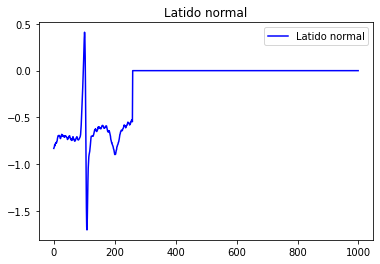

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_total[ind_class_0], color="blue", label="Latido normal")
plt.title("Latido normal")
plt.legend()
plt.show()

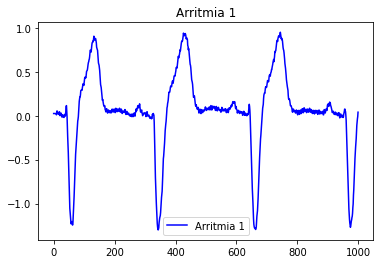

In [ ]:
plt.plot(X_total[ind_class_1], color="blue", label="Arritmia 1")
plt.title("Arritmia 1")
plt.legend()
plt.show()

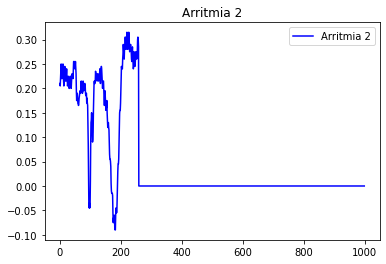

In [ ]:
plt.plot(X_total[ind_class_2], color="blue", label="Arritmia 2")
plt.title("Arritmia 2")
plt.legend()
plt.show()

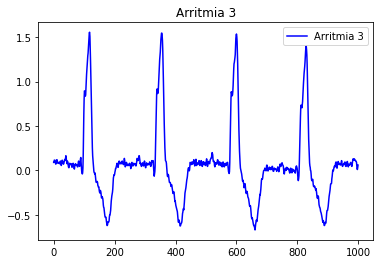

In [ ]:
plt.plot(X_total[ind_class_3], color="blue", label="Arritmia 3")
plt.title("Arritmia 3")
plt.legend()
plt.show()

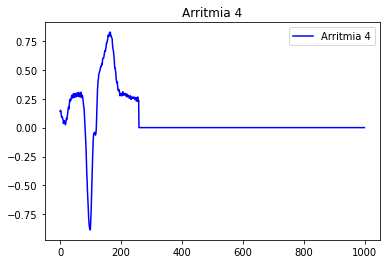

In [ ]:
plt.plot(X_total[ind_class_4], color="blue", label="Arritmia 4")
plt.title("Arritmia 4")
plt.legend()
plt.show()

Tras esta lectura tenemos una secuencia de 5000 segmentos con longitud 1000 cada uno de ellos. A continuación vamos a usar la librería TSFEDL para definir una red neuronal que nos ayude a clasificar los segmentos.

In [ ]:
import keras
from keras import layers
import tensorflow as tf
import sys
from TSFEDL.models_keras import OhShuLih

# Definimos nuestra capa de entrada
# La entrada tiene que ser una matriz 3D de dimensiones:
# [None, T, V].  La primera dimension, puesta a None, indica el nº de observaciones. Lo dejamos a None para indicar un número indefinido de observaciones.
# T es el número de timesteps de cada serie temporal. En este ejemplo, 1000.
# V es el nº de variables que conforman el problema. Este problema es univariable, por tanto V = 1
input_layer = keras.Input(shape=(X.shape[1], X.shape[2]))

# Definimos nuestro modelo OhShuLih:
model_ = OhShuLih(input_tensor=input_layer, include_top=False)

# Conectamos la capa de entrada al modelo OhShuLih mediante la API funcional de Keras:
x = model_(input_layer)

# Tras esto, siguiendo la API funcional, añadimos varias capas densas y una de salida softmax:
# Siguiendo el paper de OhShuLih, tenemos 3 capas de 20, 10 y 5 units. La última es softmax:
x = layers.Flatten()(x)
x = layers.Dense(units=20, activation=tf.nn.relu, name="dense_1")(x)
x = layers.Dense(units=10, activation=tf.nn.relu, name="dense_2")(x)
# Esta capa produce como salida un vector de tamaño 5 con valores entre 0 y 1 que pueden ser considerados como probabilidades. La posición del vector con mayor probabilidad
# se tomará como la clase predicha por el modelo
output = layers.Dense(units=5, activation=tf.nn.softmax, name="output")(x)

# Finalmente, creamos el modelo definitivo:
model = keras.Model(inputs=input_layer, outputs=output)

model_.summary()
model.summary()

Model: "OhShuLih"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 1038, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1019, 3)           60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 509, 3)            0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 527, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 518, 6)            180       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 259, 6)            0  

Con el anterior campo de código queda el modelo definido listo para entrenarlo. Como nuestro modelo tiene como salida una capa con 5 neuronas tenemos que convertir las etiquetas a un vector. Para hacer esto simplemente asociamos la etiqueta con la posición del vector, es decir, la etiqueta 0 se corresponde con [1,0,0,0,0], la etiqueta 1 con [0,1,0,0,0] y así sucesivamente.

In [ ]:
y_hot_encoded = np.zeros((y.size, y.max()+1))
y_hot_encoded[np.arange(y.size), y] = 1
y_hot_encoded

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

Ahora vamos a definir la compilación de nuestro modelo. Para ello vamos a utilizar el optimizador Adam, la función de pérdida categorical crossentropy y como métrica de entrenamiento el accuracy o porcentaje de acierto. Entrenaremos nuestro modelo usando lotes de 2048 segmentos durante 100 épocas. Es importante que antes de realizar el entrenamiento hagamos una división en train y test para poder separar los datos con los que obtenemos los resultados de los que empleamos para entrenar nuestro modelo. Emplearemos un 80% de los datos para entrenar y un 20% para comprobar nuestros resultados.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_hot_encoded, test_size=0.2, random_state=123456789)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
             metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=2048, epochs=100, validation_split=0.1, workers=-1)
                    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="loss")])

Epoch 1/100
2/2 [==============================] - 11s 1s/step - loss: 1.6064 - accuracy: 0.3336 - val_loss: 1.6016 - val_accuracy: 0.4825
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 1.5997 - accuracy: 0.4864 - val_loss: 1.5945 - val_accuracy: 0.4825
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 1.5922 - accuracy: 0.4864 - val_loss: 1.5869 - val_accuracy: 0.4825
Epoch 4/100
2/2 [==============================] - 1s 546ms/step - loss: 1.5842 - accuracy: 0.4864 - val_loss: 1.5787 - val_accuracy: 0.4825
Epoch 5/100
2/2 [==============================] - 1s 513ms/step - loss: 1.5754 - accuracy: 0.4864 - val_loss: 1.5696 - val_accuracy: 0.4825
Epoch 6/100
2/2 [==============================] - 1s 462ms/step - loss: 1.5659 - accuracy: 0.4864 - val_loss: 1.5596 - val_accuracy: 0.4825
Epoch 7/100
2/2 [==============================] - 1s 460ms/step - loss: 1.5552 - accuracy: 0.4864 - val_loss: 1.5485 - val_accuracy: 0.4825
Epoch 8/100
2/2 [====

Ahora comprobaremos los resultados obtenidos. Para ello lo que vamos a hacer es predecir con nuestra red sobre el conjunto de test. Tras esto emplearemos la función de sklearn accuracy_score para calcular el porcentaje de acierto obtenido.

In [ ]:
from sklearn.metrics import accuracy_score

# Predecimos con nuestra red, la salida será un vector de tamaño 5 para cada segmento.
pred = model.predict(X_test)
# Con la función argmax nos quedamos con el índice con mayor valor de la predicción, es decir, la clase.
pred_argmax = np.argmax(pred,axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
# Obtenemos el accuracy.
acc = accuracy_score(y_test_argmax,pred_argmax)

print("Accuracy: " + str(acc))

Accuracy: 0.764


# Detección de anomalías usando un autoencoder

Ahora vamos a abordar el mismo problema pero desde otra perspectiva: la detección de anomalías. Para ello vamos a tomar cada uno de los segmentos y vamos a entrenar un autoencoder. El objetivo va a ser diferenciar la clase "N" (identificada con el número 0), es decir latido normal, del resto que implican una arritmia. Para ello vamos a tomar del conjunto de datos original 5000 segmentos de train. Eliminaremos las secuencias que tengan una arritmia y entrenaremos con el resto. Después tomaremos las siguientes 1000 secuencias y evaluaremos.

In [ ]:
X, y = read_MIT_BIH(dir)

reading data...
done.


In [ ]:
X_train = X[:5000]
y_train = y[:5000]
X_test = X[5000:6000]
y_test = y[5000:6000]

In [ ]:
X_train = X_train[y_train==0]

Debemos tener en cuenta que no hay muchos datos para poder entrenar este tipo de red, por lo que los resultados estarán limitados por la disponibilidad de datos. A mayor arquitectura de red más datos necesitamos para obtener información.

In [ ]:
print(len(X_train))

275


Ahora vamos a definir el modelo autoencoder a emplear y ajustar las dimensiones de entrada y salida del mismo a nuestros datos.

In [ ]:
from TSFEDL.models_keras import YildirimOzal

# Tomamos como dimensiones de nuevo las mismas que en el modelo anterior
input_layer = keras.Input(shape=(X.shape[1], X.shape[2]))

# Definimos nuestro modelo YildirimOzal. Cabe destacar que esta función devuelve 3 modelos. En primer lugar el modelo autoencoder (el que nos interesa) que se encarga de
# llevar los datos originales a una dimensionalidad reducida y devolverlos a su dimensión original, el modelo encoder que sólo lleva a la dimensión reducida y por 
# último el modelo decoder que lleva desde la dimensión reducida a la dimensión original reconstruida. En este caso sólo queremos el modelo autoencoder y por tanto señalamos
# los campos que vamos a descatar con un guión bajo
model, _, _ = YildirimOzal(input_tensor=input_layer, include_top=False)

model.summary()

Model: "YildirimOzal_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 16)          96        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 64)           5184      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 3

Ahora vamos a entrenar nuestro modelo con las secuencias normales. Emplearemos 100 épocas con lotes de segmentos de 128. Ahora debemos poner en fit el dataset de partida X_train y el dataset destino X_train de nuevo. De esta forma el modelo aprenderá cómo reconstruir X_train a partir de si mismo reduciendo la dimensionalidad.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.mean_squared_error)

history = model.fit(X_train, X_train, batch_size=128, epochs=100, validation_split=0.1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="loss")])

Epoch 1/100
2/2 [==============================] - 2s 254ms/step - loss: 0.0391 - val_loss: 0.0514
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0386 - val_loss: 0.0516
Epoch 3/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0392 - val_loss: 0.0515
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0386 - val_loss: 0.0514
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0388 - val_loss: 0.0513
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0387 - val_loss: 0.0514
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0385 - val_loss: 0.0515
Epoch 8/100
2/2 [==============================] - 0s 43ms/step - loss: 0.0387 - val_loss: 0.0515
Epoch 9/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0386 - val_loss: 0.0514
Epoch 10/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0385 - val_loss: 0.0514
Epoch 11/100
2/2 [

Una vez entrenado el modelo tenemos que predecir las secuencias de test. Cabe destacar que en este caso la predicción no es una etiqueta, si no un vector del mismo tamaño que la entrada que pretende reconstruir la misma con el menor error posible en caso de que sea normal. Por contra cuando esta no es normal (no ha sido incluída en el entrenamiento) el error de reconstrucción será mayor y por tanto podremos reconocer las arritmias.

In [ ]:
from sklearn.metrics import mean_squared_error

pred = model.predict(X_test).reshape((1000,1000))
X_test = X_test.reshape((1000,1000))
mse = np.mean((X_test - pred)**2, axis=1)
largest = np.argsort(mse)[-10:]
lowest = np.argsort(mse)[:10]
print(mse[largest])
print(y_test[largest])

[0.93752563 1.0906898  1.2547791  1.2752877  1.3076724  1.5583192
 2.2051978  2.6934443  3.326564   3.6170454 ]
[4 2 4 2 2 4 2 2 2 2]


Podemos ver en los resultados que la mayoría de las etiquetas obtenidas no son cero, es decir, entre los 10 segmentos de test con mayor error de reconstrucción la mayoría son arritmias por lo que nuestro modelo está siendo capaz de diferenciar el latido normal del anómalo.

A continuación visualizamos el segmento que tiene menor y mayor error de reconstrucción respectivamente. 

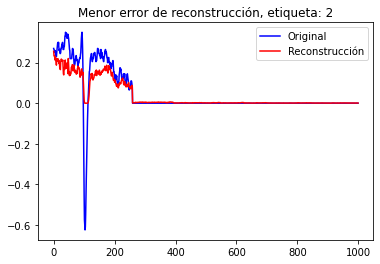

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_test[lowest[0]], color="blue", label="Original")
plt.plot(pred[lowest[0]], color="red", label="Reconstrucción")
plt.title("Menor error de reconstrucción, etiqueta: " + str(y_test[lowest[0]]))
plt.legend()
plt.show()

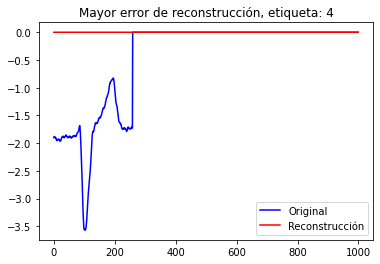

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_test[largest[0]], color="blue", label="Original")
plt.plot(pred[largest[0]], color="red", label="Reconstrucción")
plt.title("Mayor error de reconstrucción, etiqueta: " + str(y_test[largest[0]]))
plt.legend()
plt.show()

Como podemos ver en el primer segmento el error es bajo y la red ha sido capaz de modelarlo aproximadamente, no obstante no se obtiene el mejor de los ajustes por la reducida cantidad de datos. Por otro lado podemos ver que en el caso del segmento con mayor error de reconstrucción nuestra red no ha sido capaz de modelarlo ya que este tipo de datos no estaban presentes en el entrenamiento. De esta forma nuestra red tiende a cometer un error mayor en datos no vistos (latidos anómalos) y un error bajo en datos ya vistos (latidos normales).